![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FDev&dt=BQML+Predictions+-+Remote+Model.ipynb)

# BQML Predictions With Remote Model (Vertex AI)

---
## Setup

### Package Installs (if needed)

This notebook uses the Python Clients for
- Google Service Usage
    - to enable APIs (BigQuery Connection)

The cells below check to see if the required Python libraries are installed.  If any are not it will print a message to do the install with the associated pip command to use.  These installs must be completed before continuing this notebook.

In [1]:
try:
    import google.cloud.service_usage_v1
except ImportError:
    print('You need to pip install google-cloud-service-usage')
    !pip install google-cloud-service-usage -q

### Environment

inputs:

In [2]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [3]:
REGION = 'us-central1'
EXPERIMENT = '03a'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [4]:
from google.cloud import bigquery
from google.cloud import aiplatform
from google.cloud import service_usage_v1

from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics

from google.api import httpbody_pb2
import json

clients:

In [5]:
bq = bigquery.Client(project=PROJECT_ID)
aiplatform.init(project=PROJECT_ID, location=REGION)
su_client = service_usage_v1.ServiceUsageClient()

### Enable APIs

BigQuery Remote models use the BigQuery Connection API. 

Options for enabeling:  In this notebook option 2 is used.
 1. Use the APIs & Services page in the console: https://console.cloud.google.com/apis
     - `+ Enable APIs and Services`
     - Search for BigQuery Connection
 2. Use [Google Service Usage](https://cloud.google.com/service-usage/docs) API from Python
     - [Python Client For Service Usage](https://github.com/googleapis/python-service-usage)
     - [Python Client Library Documentation](https://cloud.google.com/python/docs/reference/serviceusage/latest)
     
The following code cells use the Service Usage Client to:
- get the state of the service
- if 'DISABLED':
    - Try enabling the service and return the state after trying
- if 'ENABLED' print the state for confirmation

#### BigQuery Connection

In [6]:
bigqueryconnection = su_client.get_service(
    request = service_usage_v1.GetServiceRequest(
        name = f'projects/{PROJECT_ID}/services/bigqueryconnection.googleapis.com'
    )
).state.name


if bigqueryconnection == 'DISABLED':
    print(f'API is currently {bigqueryconnection} for project: {PROJECT_ID}')
    print(f'Trying to Enable...')
    operation = su_client.enable_service(
        request = service_usage_v1.EnableServiceRequest(
            name = f'projects/{PROJECT_ID}/services/bigqueryconnection.googleapis.com'
        )
    )
    response = operation.result()
    if response.service.state.name == 'ENABLED':
        print(f'API is now enabled for project: {PROJECT_ID}')
    else:
        print(response)
else:
    print(f'API already enabled for project: {PROJECT_ID}')

API already enabled for project: statmike-mlops-349915


---
## Get Vertex AI Endpoint

In [7]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    print(f"There does not appear to be an endpoint for SERIES = {SERIES}")

Endpoint Exists: projects/1026793852137/locations/us-central1/endpoints/4867252103141130240


In [8]:
endpoint.display_name

'03'

In [9]:
print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/4867252103141130240?project=statmike-mlops-349915


---
## Get The Deployed Model

In [10]:
deployed_model = aiplatform.Model(
    model_name = endpoint.list_models()[0].model+f'@{endpoint.list_models()[0].model_version_id}'
)

In [11]:
deployed_model.display_name

'03_03a'

In [12]:
deployed_model.versioned_resource_name

'projects/1026793852137/locations/us-central1/models/model_03_03a@3'

In [13]:
deployed_model.uri

'gs://statmike-mlops-349915/03/03a/models/20230222115533/model'

In [64]:
!gsutil ls {deployed_model.uri}

gs://statmike-mlops-349915/03/03a/models/20230222115533/model/
gs://statmike-mlops-349915/03/03a/models/20230222115533/model/explanation_metadata.json
gs://statmike-mlops-349915/03/03a/models/20230222115533/model/saved_model.pb
gs://statmike-mlops-349915/03/03a/models/20230222115533/model/variables/


In [14]:
deployed_model.version_id

'3'

In [15]:
print(f'Review the model in the Vertex AI Model Registry:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{deployed_model.name}/versions/{deployed_model.version_id}/properties?project={PROJECT_ID}')

Review the model in the Vertex AI Model Registry:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_03_03a/versions/3/properties?project=statmike-mlops-349915


---
## Retrieve Records For Prediction & Explanation

In [16]:
n = 10
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, {VAR_OMIT}, splits)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE splits='TEST'
        LIMIT {n}
        """
).to_dataframe()

In [17]:
pred

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,35337,1.092844,-0.013230,1.359829,2.731537,-0.707357,0.873837,-0.796130,0.437707,0.396770,...,-0.240428,0.037603,0.380026,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.0
1,60481,1.238973,0.035226,0.063003,0.641406,-0.260893,-0.580097,0.049938,-0.034733,0.405932,...,-0.265080,-0.060003,-0.053585,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.0
2,139587,1.870539,0.211079,0.224457,3.889486,-0.380177,0.249799,-0.577133,0.179189,-0.120462,...,-0.374356,0.196006,0.656552,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.0
3,162908,-3.368339,-1.980442,0.153645,-0.159795,3.847169,-3.516873,-1.209398,-0.292122,0.760543,...,-0.923275,-0.545992,-0.252324,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.0
4,165236,2.180149,0.218732,-2.637726,0.348776,1.063546,-1.249197,0.942021,-0.547652,-0.087823,...,-0.250653,0.234502,0.825237,-0.176957,0.563779,0.730183,0.707494,-0.131066,-0.090428,0.0
5,62606,1.199408,0.352007,0.379645,1.372017,0.291347,0.524919,-0.117555,0.132907,-0.935169,...,-0.042979,-0.050291,-0.126609,-0.022218,-0.599026,0.258188,0.928721,-0.058988,-0.008856,0.0
6,90719,1.937447,0.337882,-0.000630,3.816486,0.276515,1.079842,-0.730626,0.197353,1.137566,...,-0.315667,-0.038376,0.208914,0.160189,-0.015145,-0.162678,-0.000843,-0.018178,-0.039339,0.0
7,113350,1.891900,0.401086,-0.119983,4.047500,0.049952,0.192793,-0.108512,-0.040400,-0.390391,...,-0.267639,0.094177,0.613712,0.070986,0.079543,0.135219,0.128961,0.003667,-0.045079,0.0
8,156499,0.060003,1.461355,0.378915,2.835455,1.626526,-0.164732,1.551858,-0.412927,-1.735264,...,-0.175275,0.042293,0.277536,-0.123379,1.081552,-0.053079,-0.149809,-0.314438,-0.216539,0.0
9,73902,-1.859260,2.158799,1.085671,2.615483,0.246660,2.133925,-1.569015,-2.612353,-1.312509,...,0.590142,-0.867178,-0.700479,0.231972,-1.374527,0.140285,0.128806,0.153606,0.092042,0.0


Remove columns not included as features in the model:

In [18]:
newobs = pred.to_dict(orient='records')
newobs[0]

{'Time': 35337,
 'V1': 1.0928441854981998,
 'V2': -0.0132303486713432,
 'V3': 1.35982868199426,
 'V4': 2.7315370965921004,
 'V5': -0.707357349219652,
 'V6': 0.8738370029866129,
 'V7': -0.7961301510622031,
 'V8': 0.437706509544851,
 'V9': 0.39676985012996396,
 'V10': 0.587438102569443,
 'V11': -0.14979756231827498,
 'V12': 0.29514781622888103,
 'V13': -1.30382621882143,
 'V14': -0.31782283120234495,
 'V15': -2.03673231037199,
 'V16': 0.376090905274179,
 'V17': -0.30040350116459497,
 'V18': 0.433799615590844,
 'V19': -0.145082264348681,
 'V20': -0.240427548108996,
 'V21': 0.0376030733329398,
 'V22': 0.38002620963091405,
 'V23': -0.16764742731151097,
 'V24': 0.0275573495476881,
 'V25': 0.59211469704354,
 'V26': 0.219695164116351,
 'V27': 0.0369695108704894,
 'V28': 0.010984441006191,
 'Amount': 0.0}

In [19]:
len(newobs)

10

In [20]:
prediction = endpoint.predict(instances = newobs[0:1])
prediction

Prediction(predictions=[{'Class_values': ['1', '0'], 'predicted_Class': ['0'], 'Class_probs': [0.2352047638246847, 0.7647952361753153]}], deployed_model_id='5304461906809978880', model_version_id='3', model_resource_name='projects/1026793852137/locations/us-central1/models/model_03_03a', explanations=None)

In [21]:
prediction.predictions[0]

{'Class_values': ['1', '0'],
 'predicted_Class': ['0'],
 'Class_probs': [0.2352047638246847, 0.7647952361753153]}

---
## BQML Remote Model

### BigQuery Cloud Resource Connection
https://cloud.google.com/bigquery/docs/create-cloud-resource-connection

In [22]:
!bq version

This is BigQuery CLI 2.0.75


In [68]:
!bq ls --connection --location={REGION} --project_id={PROJECT_ID}

                    name                     friendlyName   description    Last modified         type        hasCredential                                             properties                                            
 ------------------------------------------ -------------- ------------- ----------------- ---------------- --------------- ------------------------------------------------------------------------------------------------ 
  1026793852137.us-central1.vertex_connect                                22 Feb 14:29:36   CLOUD_RESOURCE   False           {"serviceAccountId": "bqcx-1026793852137-d9vv@gcp-sa-bigquery-condel.iam.gserviceaccount.com"}  


In [ ]:
!bq mk --connection --location={REGION} --project_id={PROJECT_ID} --connection_type=CLOUD_RESOURCE vertex_connect

In [24]:
!bq show --connection {PROJECT_ID}.{REGION}.vertex_connect

Connection statmike-mlops-349915.us-central1.vertex_connect

                    name                     friendlyName   description    Last modified         type        hasCredential                                             properties                                            
 ------------------------------------------ -------------- ------------- ----------------- ---------------- --------------- ------------------------------------------------------------------------------------------------ 
  1026793852137.us-central1.vertex_connect                                22 Feb 14:29:36   CLOUD_RESOURCE   False           {"serviceAccountId": "bqcx-1026793852137-d9vv@gcp-sa-bigquery-condel.iam.gserviceaccount.com"}  



Grant This Service Account the role: [Vertex AI User](https://cloud.google.com/vertex-ai/docs/general/access-control#aiplatform.user)
                                                      
Do This in the Console:
- Console > IAM > + Grand Access:
    - New Principal = <enter value of serviceAccountId above>
    - Role = Vertex AI User
    - Click Save

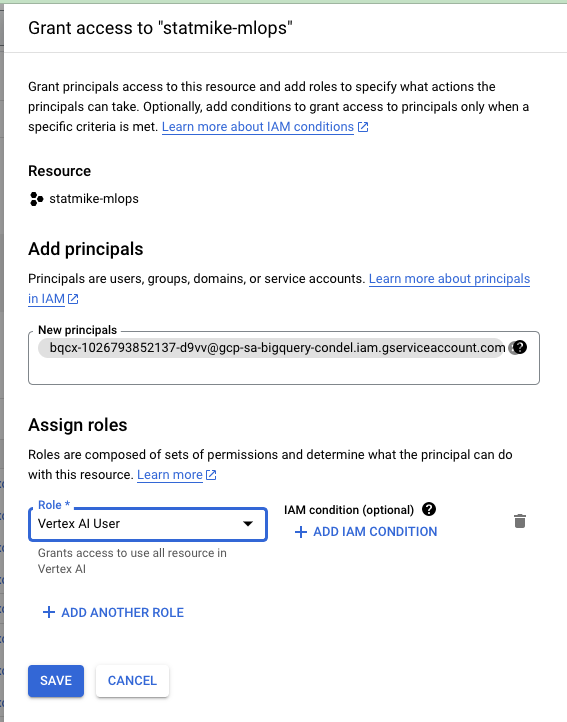

### Model Inputs and Outputs

```
MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:
signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['image_bytes'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: encoded_image_string_tensor:0
    inputs['key'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: key:0
```

In [25]:
import tensorflow as tf
reloaded_model = tf.saved_model.load(deployed_model.uri)
print(list(reloaded_model.signatures.keys())[0])

2023-02-23 23:47:01.515050: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2299995000 Hz
2023-02-23 23:47:01.516783: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563cd5c35740 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-02-23 23:47:01.516830: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-02-23 23:47:01.521370: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


serving_default


In [26]:
reloaded_model.signatures

_SignatureMap({'serving_default': <ConcreteFunction pruned(V17, V4, V15, V22, V12, V18, V2, V11, V13, V8, V23, Time, V19, V5, V27, V6, V24, V9, V21, V16, V1, V26, V20, V3, V7, V14, V10, V28, V25, Amount) at 0x7F1AEC4EEE10>})

In [27]:
reloaded_model.signatures['serving_default']

<ConcreteFunction pruned(V17, V4, V15, V22, V12, V18, V2, V11, V13, V8, V23, Time, V19, V5, V27, V6, V24, V9, V21, V16, V1, V26, V20, V3, V7, V14, V10, V28, V25, Amount) at 0x7F1AEC4EEE10>

In [28]:
!saved_model_cli show --dir {deployed_model.uri} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Amount'] tensor_info:
        dtype: DT_DOUBLE
        shape: (-1)
        name: Amount:0
    inputs['Time'] tensor_info:
        dtype: DT_DOUBLE
        shape: (-1)
        name: Time:0
    inputs['V1'] tensor_info:
        dtype: DT_DOUBLE
        shape: (-1)
        name: V1:0
    inputs['V10'] tensor_info:
        dtype: DT_DOUBLE
        shape: (-1)
        name: V10:0
    inputs['V11'] tensor_info:
        dtype: DT_DOUBLE
        shape: (-1)
        name: V11:0
    inputs['V12'] tensor_info:
        dtype: DT_DOUBLE
        shape: (-1)
        name: V12:0
    inputs['V13'] tensor_info:
        dtype: DT_DOUBLE
        shape: (-1)
        name: V13:0
    inputs['V14'] tensor_info:
        dtype: DT_DOUBLE
        shape: (-1)
        name: V14:0
    inputs['V15'] tensor_info:
        dtype: DT

### Create Remote Model

In [69]:
deployed_model.uri

'gs://statmike-mlops-349915/03/03a/models/20230222115533/model'

In [70]:
deployed_model.name

'model_03_03a'

In [71]:
endpoint.name

'4867252103141130240'

In [72]:
endpoint.resource_name

'projects/1026793852137/locations/us-central1/endpoints/4867252103141130240'

In [127]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.vertexai_{deployed_model.name}`
INPUT (
    Amount FLOAT64,
    Time INT64,
    V1 FLOAT64,
    V2 FLOAT64,
    V3 FLOAT64,
    V4 FLOAT64,
    V5 FLOAT64,
    V6 FLOAT64,
    V7 FLOAT64,
    V8 FLOAT64,
    V9 FLOAT64,
    V10 FLOAT64,
    V11 FLOAT64,
    V12 FLOAT64,
    V13 FLOAT64,
    V14 FLOAT64,
    V15 FLOAT64,
    V16 FLOAT64,
    V17 FLOAT64,
    V18 FLOAT64,
    V19 FLOAT64,
    V20 FLOAT64,
    V21 FLOAT64,
    V22 FLOAT64,
    V23 FLOAT64,
    V24 FLOAT64,
    V25 FLOAT64,
    V26 FLOAT64,
    V27 FLOAT64,
    V28 FLOAT64
)
OUTPUT (
    Class_probs ARRAY<FLOAT64>,
    Class_values ARRAY<STRING>,
    predicted_Class ARRAY<STRING>
)
REMOTE WITH CONNECTION `{PROJECT_ID}.{REGION}.vertex_connect`
OPTIONS(
    endpoint = 'https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}'
)
"""
job = bq.query(query = query)
job.result()

### Predict with ML.PREDICT

In [133]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.vertexai_{deployed_model.name}`,(
    SELECT * EXCEPT(splits, {VAR_TARGET}, {VAR_OMIT})
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST'
    #LIMIT 10
    #WHERE transaction_id = 'a1b10547-d270-48c0-b902-7a0f735dadc7'
    )
  )
"""
pred = bq.query(query = query).to_dataframe()

In [134]:
pred

,Class_probs,Class_values,predicted_Class,Time,V1,V2,V3,V4,V5,V6,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,"[0.2352047638246846, 0.7647952361753154]","[1, 0]",[0],35337,1.092844,-0.013230,1.359829,2.731537,-0.707357,0.873837,...,-0.240428,0.037603,0.380026,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.00
1,"[0.08617354284057765, 0.9138264571594223]","[1, 0]",[0],60481,1.238973,0.035226,0.063003,0.641406,-0.260893,-0.580097,...,-0.265080,-0.060003,-0.053585,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.00
2,"[0.3179054951019253, 0.6820945048980747]","[1, 0]",[0],139587,1.870539,0.211079,0.224457,3.889486,-0.380177,0.249799,...,-0.374356,0.196006,0.656552,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.00
3,"[0.03687700128134301, 0.963122998718657]","[1, 0]",[0],162908,-3.368339,-1.980442,0.153645,-0.159795,3.847169,-3.516873,...,-0.923275,-0.545992,-0.252324,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.00
4,"[0.05563223412843869, 0.9443677658715613]","[1, 0]",[0],165236,2.180149,0.218732,-2.637726,0.348776,1.063546,-1.249197,...,-0.250653,0.234502,0.825237,-0.176957,0.563779,0.730183,0.707494,-0.131066,-0.090428,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28497,"[0.06557008875984105, 0.934429911240159]","[1, 0]",[0],39892,-0.886023,-3.746952,-0.013576,1.026757,-1.797836,1.264180,...,1.896435,0.483613,-0.649644,-0.759476,-0.179642,-0.429041,0.846207,-0.197371,0.173713,1023.22
28498,"[0.99806510457691, 0.00193489542309]","[1, 0]",[1],4462,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,...,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93
28499,"[0.1022946465181041, 0.897705353481896]","[1, 0]",[0],42801,0.340725,-1.225499,-0.745517,1.026148,0.654991,2.089517,...,0.451794,0.299103,0.238042,-0.466934,-1.871375,0.447112,-0.148891,-0.000906,0.044125,383.86
28500,"[0.01428514520219138, 0.9857148547978086]","[1, 0]",[0],146852,-4.233290,0.378911,-5.491528,0.019751,-3.016256,-0.876330,...,-1.061182,0.128130,1.469656,0.245055,0.269178,-0.825780,0.729517,1.180039,-0.675639,543.72


Troubleshooting:

In [77]:
endpoint.predict(instances = newobs[0:1])

Prediction(predictions=[{'Class_values': ['1', '0'], 'predicted_Class': ['0'], 'Class_probs': [0.2352047638246847, 0.7647952361753153]}], deployed_model_id='5304461906809978880', model_version_id='3', model_resource_name='projects/1026793852137/locations/us-central1/models/model_03_03a', explanations=None)

In [79]:
{'instances': newobs[0:1]}

{'instances': [{'Time': 35337,
   'V1': 1.0928441854981998,
   'V2': -0.0132303486713432,
   'V3': 1.35982868199426,
   'V4': 2.7315370965921004,
   'V5': -0.707357349219652,
   'V6': 0.8738370029866129,
   'V7': -0.7961301510622031,
   'V8': 0.437706509544851,
   'V9': 0.39676985012996396,
   'V10': 0.587438102569443,
   'V11': -0.14979756231827498,
   'V12': 0.29514781622888103,
   'V13': -1.30382621882143,
   'V14': -0.31782283120234495,
   'V15': -2.03673231037199,
   'V16': 0.376090905274179,
   'V17': -0.30040350116459497,
   'V18': 0.433799615590844,
   'V19': -0.145082264348681,
   'V20': -0.240427548108996,
   'V21': 0.0376030733329398,
   'V22': 0.38002620963091405,
   'V23': -0.16764742731151097,
   'V24': 0.0275573495476881,
   'V25': 0.59211469704354,
   'V26': 0.219695164116351,
   'V27': 0.0369695108704894,
   'V28': 0.010984441006191,
   'Amount': 0.0}]}

In [101]:
payload = json.dumps({'instances': newobs[0:1]})
payload

'{"instances": [{"Time": 35337, "V1": 1.0928441854981998, "V2": -0.0132303486713432, "V3": 1.35982868199426, "V4": 2.7315370965921004, "V5": -0.707357349219652, "V6": 0.8738370029866129, "V7": -0.7961301510622031, "V8": 0.437706509544851, "V9": 0.39676985012996396, "V10": 0.587438102569443, "V11": -0.14979756231827498, "V12": 0.29514781622888103, "V13": -1.30382621882143, "V14": -0.31782283120234495, "V15": -2.03673231037199, "V16": 0.376090905274179, "V17": -0.30040350116459497, "V18": 0.433799615590844, "V19": -0.145082264348681, "V20": -0.240427548108996, "V21": 0.0376030733329398, "V22": 0.38002620963091405, "V23": -0.16764742731151097, "V24": 0.0275573495476881, "V25": 0.59211469704354, "V26": 0.219695164116351, "V27": 0.0369695108704894, "V28": 0.010984441006191, "Amount": 0.0}]}'

In [121]:
with open(f'request.json','w') as file:
    file.write(json.dumps({'instances': newobs[0:1]}))

In [123]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "predicted_Class": [
        "0"
      ],
      "Class_values": [
        "1",
        "0"
      ],
      "Class_probs": [
        0.23520476382468469,
        0.76479523617531531
      ]
    }
  ],
  "deployedModelId": "5304461906809978880",
  "model": "projects/1026793852137/locations/us-central1/models/model_03_03a",
  "modelDisplayName": "03_03a",
  "modelVersionId": "3"
}


In [ ]:
-d '{"instances": [{"Time": 35337, "V1": 1.0928441854981998, "V2": -0.0132303486713432, "V3": 1.35982868199426, "V4": 2.7315370965921004, "V5": -0.707357349219652, "V6": 0.8738370029866129, "V7": -0.7961301510622031, "V8": 0.437706509544851, "V9": 0.39676985012996396, "V10": 0.587438102569443, "V11": -0.14979756231827498, "V12": 0.29514781622888103, "V13": -1.30382621882143, "V14": -0.31782283120234495, "V15": -2.03673231037199, "V16": 0.376090905274179, "V17": -0.30040350116459497, "V18": 0.433799615590844, "V19": -0.145082264348681, "V20": -0.240427548108996, "V21": 0.0376030733329398, "V22": 0.38002620963091405, "V23": -0.16764742731151097, "V24": 0.0275573495476881, "V25": 0.59211469704354, "V26": 0.219695164116351, "V27": 0.0369695108704894, "V28": 0.010984441006191, "Amount": 0.0}]}'

In [ ]:
-d "{'instances': [{ 'f1': 1.0, 'f2': 5.0 }, {'f1':10.0, 'f2': 2.0}]}"

In [ ]:
prediction = !curl -s POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

prediction

In [ ]:
{"instances": [{"Time": 35337, "V1": 1.0928441854981998, "V2": -0.0132303486713432, "V3": 1.35982868199426, "V4": 2.7315370965921004, "V5": -0.707357349219652, "V6": 0.8738370029866129, "V7": -0.7961301510622031, "V8": 0.437706509544851, "V9": 0.39676985012996396, "V10": 0.587438102569443, "V11": -0.14979756231827498, "V12": 0.29514781622888103, "V13": -1.30382621882143, "V14": -0.31782283120234495, "V15": -2.03673231037199, "V16": 0.376090905274179, "V17": -0.30040350116459497, "V18": 0.433799615590844, "V19": -0.145082264348681, "V20": -0.240427548108996, "V21": 0.0376030733329398, "V22": 0.38002620963091405, "V23": -0.16764742731151097, "V24": 0.0275573495476881, "V25": 0.59211469704354, "V26": 0.219695164116351, "V27": 0.0369695108704894, "V28": 0.010984441006191, "Amount": 0.0}], "signature_name": "serving_default"}

In [63]:
endpoint.resource_name

'projects/1026793852137/locations/us-central1/endpoints/4867252103141130240'

In [ ]:
'projects/1026793852137/locations/us-central1/endpoints/4867252103141130240'